<a href="https://colab.research.google.com/github/Rituparna22/Object-Identification/blob/main/Object_detection_using_Aquarium_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Object detection

This is a short and simple project to train a Faster RCNN model to do obeject detection.

We recommend you to use the free GPU by Colab for this code.
  
Here are all the necessary libraries.

In [1]:
# linear algebra
import numpy as np
# data processing, CSV file I/O (e.g. pd.read_csv)
import pandas as pd
import os
import torch
import torchvision
from torchvision import datasets, models
from torchvision.transforms import functional as FT
from torchvision import transforms as T
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import DataLoader, sampler, random_split, Dataset
import copy
import math
from PIL import Image
# opencv
import cv2
# our data augmentation library
import albumentations as A
import matplotlib.pyplot as plt
%matplotlib inline

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.23 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [3]:
import warnings
warnings.filterwarnings("ignore")
from collections import defaultdict, deque
import datetime
import time
# display progress bar
from tqdm import tqdm
# plot bounding box
from torchvision.utils import draw_bounding_boxes


PyCOCOTools provides many utilities for dealing with datasets in the COCO format, and if you want, you could evaluate the model's performance on the dataset with some of the utilities provided with this library.

In [4]:
print(torch.__version__)
print(torchvision.__version__)

2.5.1+cu121
0.20.1+cu121


In [5]:
# our dataset is in cocoformat, we will need pypcoco tools
!pip install pycocotools
from pycocotools.coco import COCO

In [6]:
from albumentations.pytorch import ToTensorV2

We use albumentations as our data augmentation library due to its capability to deal with bounding boxes in multiple formats

In [7]:
def get_transforms(train=False):
    if train:
        transform = A.Compose([
            A.Resize(600, 600), # our input size can be 600px
            A.HorizontalFlip(p=0.3),
            A.VerticalFlip(p=0.3),
            A.RandomBrightnessContrast(p=0.1),
            A.ColorJitter(p=0.1),
            ToTensorV2()
        ], bbox_params=A.BboxParams(format='coco'))
    else:
        transform = A.Compose([
            A.Resize(600, 600), # our input size can be 600px
            ToTensorV2()
        ], bbox_params=A.BboxParams(format='coco'))
    return transform

# **Dataset**
First, you need to download the Aquarium dataset in Kaggle:
https://www.kaggle.com/datasets/sharansmenon/aquarium-dataset and upload to your Google Drive.

This is our dataset class.
It loads all the necessary files and it processes the data so that it can be fed into the model.

In [8]:
class AquariumDetection(datasets.VisionDataset):
    def __init__(self, root, split='train', transform=None, target_transform=None, transforms=None):
        # the 3 transform parameters are reuqired for datasets.VisionDataset
        super().__init__(root, transforms, transform, target_transform)
        self.split = split #train, valid, test
        self.coco = COCO(os.path.join(root, split, "_annotations.coco.json")) # annotatiosn stored here
        self.ids = list(sorted(self.coco.imgs.keys()))
        self.ids = [id for id in self.ids if (len(self._load_target(id)) > 0)]

    def _load_image(self, id: int):
        path = self.coco.loadImgs(id)[0]['file_name']
        image = cv2.imread(os.path.join(self.root, self.split, path))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        return image
    def _load_target(self, id):
        return self.coco.loadAnns(self.coco.getAnnIds(id))

    def __getitem__(self, index):
        id = self.ids[index]
        image = self._load_image(id)
        target = self._load_target(id)
        target = copy.deepcopy(self._load_target(id))

        boxes = [t['bbox'] + [t['category_id']] for t in target] # required annotation format for albumentations
        if self.transforms is not None:
            transformed = self.transforms(image=image, bboxes=boxes)

        image = transformed['image']
        boxes = transformed['bboxes']

        new_boxes = [] # convert from xywh to xyxy
        for box in boxes:
            xmin = box[0]
            xmax = xmin + box[2]
            ymin = box[1]
            ymax = ymin + box[3]
            new_boxes.append([xmin, ymin, xmax, ymax])

        boxes = torch.tensor(new_boxes, dtype=torch.float32)

        targ = {} # here is our transformed target
        targ['boxes'] = boxes
        targ['labels'] = torch.tensor([t['category_id'] for t in target], dtype=torch.int64)
        targ['image_id'] = torch.tensor([t['image_id'] for t in target])
        targ['area'] = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0]) # we have a different area
        targ['iscrowd'] = torch.tensor([t['iscrowd'] for t in target], dtype=torch.int64)
        return image.div(255), targ # scale images
    def __len__(self):
        return len(self.ids)

Mount and load your Google Drive and replace the path to your dataset

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
from google.colab import drive
import os
from pycocotools.coco import COCO

# Step 1: Mount Google Drive
#drive.mount('/content/drive')

# Step 2: Define paths and verify structure
drive_base_path = '/content/drive/MyDrive/Projects/Aquarium Combined'
train_dir = os.path.join(drive_base_path, 'train')

print("Contents of 'Projects Aquarium Combined':")
print(os.listdir(drive_base_path))

if os.path.isdir(train_dir):
    print(f"Contents of the train directory:")
    print(os.listdir(train_dir))

    # Step 3: Specify and verify the annotation file path
    annotation_file = os.path.join(train_dir, 'annotations.coco.json')
    if os.path.exists(annotation_file):
        print(f"Annotation file found at {annotation_file}")

        # Load the COCO dataset
        coco = COCO(annotation_file)
        categories = coco.cats
        n_classes = len(categories.keys())
        print(f"Number of classes: {n_classes}")
    else:
        print(f"Annotation file not found at {annotation_file}")
else:
    print(f"Train directory not found at {train_dir}")


Contents of 'Projects Aquarium Combined':
['README.roboflow.txt', 'README.dataset.txt', 'valid', 'test', 'train']
Contents of the train directory:
['IMG_8599_MOV-2_jpg.rf.0b2b0733befaae0b08c0e04b86f295b9.jpg', 'IMG_2382_jpeg_jpg.rf.b431ad0ed94761ef82281dbe844170cc.jpg', 'IMG_2592_jpeg_jpg.rf.9c8ada079979c004ab05f15d6b66c902.jpg', 'IMG_2560_jpeg_jpg.rf.121b55027c132565ca11f89e21ea6722.jpg', 'IMG_3188_jpeg_jpg.rf.747520ca7cf3643faf40accc5db68c4d.jpg', 'IMG_8327_jpg.rf.b859bdc46f8f4aaf4d1ff2b902e276df.jpg', 'IMG_2573_jpeg_jpg.rf.b7884c20265e0dd7cefe21da58643216.jpg', 'IMG_8517_MOV-4_jpg.rf.82cc2fd5812151d35ce655a5b25f5215.jpg', 'IMG_3125_jpeg_jpg.rf.6c100391f99fd177741c11b928b7a61c.jpg', 'IMG_2313_jpeg_jpg.rf.c493f660b195b8edec3ee3fa0c626868.jpg', 'IMG_2432_jpeg_jpg.rf.b0839d3e7f6a6fbc8f15a4e0ef385b7f.jpg', 'IMG_2373_jpeg_jpg.rf.6b8f32a68ab7d25ff0cd7f977bd187fc.jpg', 'IMG_2401_jpeg_jpg.rf.9c2bfe2fea5904ab85682c15ea13eeac.jpg', 'IMG_2409_jpeg_jpg.rf.2de52b31d07502007ce8e96350212d7c.jpg', '

In [11]:
# dataset_path = "/content/drive/MyDrive/COMP534 Lab Session/Aquarium Combined"
dataset_path="/content/drive/MyDrive/Projects/Aquarium Combined"
#print(COCO)
# unzip al the iamge
#!unzip Aquarium.zip

In [12]:
#load classes
coco = COCO(os.path.join(dataset_path, "train", "_annotations.coco.json"))
categories = coco.cats
n_classes = len(categories.keys())
categories


loading annotations into memory...
Done (t=0.37s)
creating index...
index created!


{0: {'id': 0, 'name': 'creatures', 'supercategory': 'none'},
 1: {'id': 1, 'name': 'fish', 'supercategory': 'creatures'},
 2: {'id': 2, 'name': 'jellyfish', 'supercategory': 'creatures'},
 3: {'id': 3, 'name': 'penguin', 'supercategory': 'creatures'},
 4: {'id': 4, 'name': 'puffin', 'supercategory': 'creatures'},
 5: {'id': 5, 'name': 'shark', 'supercategory': 'creatures'},
 6: {'id': 6, 'name': 'starfish', 'supercategory': 'creatures'},
 7: {'id': 7, 'name': 'stingray', 'supercategory': 'creatures'}}

This code just gets a list of classes.


In [13]:
classes = [i[1]['name'] for i in categories.items()]
classes

['creatures',
 'fish',
 'jellyfish',
 'penguin',
 'puffin',
 'shark',
 'starfish',
 'stingray']

In [14]:
train_dataset = AquariumDetection(root=dataset_path, transforms=get_transforms(True))

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!


This is a sample image and its bounding boxes, this code does not get the model's output

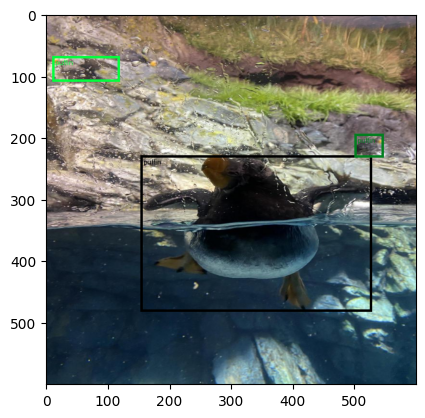

In [15]:
# Lets view a sample
sample = train_dataset[2]
img_int = torch.tensor(sample[0] * 255, dtype=torch.uint8)
plt.imshow(draw_bounding_boxes(
    img_int, sample[1]['boxes'], [classes[i] for i in sample[1]['labels']], width=4
).permute(1, 2, 0))


In [16]:
len(train_dataset)

447

# **Model**
Our model is FasterRCNN with a backbone of `MobileNetV3-Large`.
We need to change the output layers because we have just `7` classes but this model was trained on `90` classes.

In [17]:
# Load the faster rcnn model
model = models.detection.fasterrcnn_mobilenet_v3_large_fpn(pretrained=True)
# we need to change the head, get the number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features
# replace the pre-trained head with a new one
model.roi_heads.box_predictor = models.detection.faster_rcnn.FastRCNNPredictor(in_features, n_classes)

Downloading: "https://download.pytorch.org/models/fasterrcnn_mobilenet_v3_large_fpn-fb6a3cc7.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_mobilenet_v3_large_fpn-fb6a3cc7.pth
100%|██████████| 74.2M/74.2M [00:00<00:00, 124MB/s]


This is our collating function for the train dataloader, it allows us to create batches of data that can be easily pass into the model

In [18]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [19]:
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=4, collate_fn=collate_fn)

The following blocks ensures that the model can take in the data and that it will not crash during training.

In [20]:
images,targets = next(iter(train_loader))
images = list(image for image in images)
targets = [{k:v for k, v in t.items()} for t in targets]
output = model(images, targets) # just make sure this runs without error

In [21]:
device = torch.device("cpu") # use GPU to train
model = model.to(device)

# **Optimizer**
Here, we define the optimizer. If you wish to experiemnt with a larger dataset, you can also define the `LR Scheduler`.

In [22]:
# parameters and optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.01, momentum=0.9, nesterov=True, weight_decay=1e-4)

In [23]:
import sys

# **Training**
The following is a function that will train the model for one epoch. `Torchvision Object Detections` models have a loss function built in, and it will calculate the loss automatically if you pass in the **inputs** and **targets**.

In [24]:
def train_one_epoch(model, optimizer, loader, device, epoch):
    model.to(device)
    model.train()

    all_losses = []
    all_losses_dict = []

    for images, targets in tqdm(loader):
        images = list(image.to(device) for image in images)
        targets = [{k: torch.tensor(v).to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets) # the model computes the loss automatically if we pass in targets
        losses = sum(loss for loss in loss_dict.values())
        loss_dict_append = {k: v.item() for k, v in loss_dict.items()}
        loss_value = losses.item()

        all_losses.append(loss_value)
        all_losses_dict.append(loss_dict_append)

        if not math.isfinite(loss_value):
            print(f"Loss is {loss_value}, stopping trainig") # train if loss becomes infinity
            print(loss_dict)
            sys.exit(1)

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

    all_losses_dict = pd.DataFrame(all_losses_dict) # for printing
    print("Epoch {}, lr: {:.6f}, loss: {:.6f}, loss_classifier: {:.6f}, loss_box: {:.6f}, loss_rpn_box: {:.6f}, loss_object: {:.6f}".format(
        epoch, optimizer.param_groups[0]['lr'], np.mean(all_losses),
        all_losses_dict['loss_classifier'].mean(),
        all_losses_dict['loss_box_reg'].mean(),
        all_losses_dict['loss_rpn_box_reg'].mean(),
        all_losses_dict['loss_objectness'].mean()
    ))

20 Epochs should be enough to train this model for a high accuracy. You can also try with more for experimental purpose such as cheching for Overfitting, underfitting, etc..

In [25]:
num_epochs=20

for epoch in range(num_epochs):
    train_one_epoch(model, optimizer, train_loader, device, epoch)

100%|██████████| 112/112 [23:01<00:00, 12.34s/it]


Epoch 0, lr: 0.010000, loss: 0.991171, loss_classifier: 0.471730, loss_box: 0.391384, loss_rpn_box: 0.032600, loss_object: 0.095458


100%|██████████| 112/112 [22:18<00:00, 11.96s/it]


Epoch 1, lr: 0.010000, loss: 0.784676, loss_classifier: 0.350540, loss_box: 0.347530, loss_rpn_box: 0.028986, loss_object: 0.057619


100%|██████████| 112/112 [21:56<00:00, 11.75s/it]


Epoch 2, lr: 0.010000, loss: 0.712565, loss_classifier: 0.302470, loss_box: 0.334237, loss_rpn_box: 0.025868, loss_object: 0.049991


100%|██████████| 112/112 [21:26<00:00, 11.49s/it]


Epoch 3, lr: 0.010000, loss: 0.697174, loss_classifier: 0.284959, loss_box: 0.343876, loss_rpn_box: 0.025134, loss_object: 0.043205


100%|██████████| 112/112 [20:29<00:00, 10.98s/it]


Epoch 4, lr: 0.010000, loss: 0.668768, loss_classifier: 0.263825, loss_box: 0.343427, loss_rpn_box: 0.024378, loss_object: 0.037138


100%|██████████| 112/112 [19:59<00:00, 10.71s/it]


Epoch 5, lr: 0.010000, loss: 0.654340, loss_classifier: 0.254815, loss_box: 0.343911, loss_rpn_box: 0.022752, loss_object: 0.032862


100%|██████████| 112/112 [19:50<00:00, 10.63s/it]


Epoch 6, lr: 0.010000, loss: 0.644153, loss_classifier: 0.243029, loss_box: 0.347776, loss_rpn_box: 0.022415, loss_object: 0.030933


100%|██████████| 112/112 [19:32<00:00, 10.47s/it]


Epoch 7, lr: 0.010000, loss: 0.638886, loss_classifier: 0.239412, loss_box: 0.349118, loss_rpn_box: 0.021443, loss_object: 0.028913


100%|██████████| 112/112 [19:14<00:00, 10.31s/it]


Epoch 8, lr: 0.010000, loss: 0.653929, loss_classifier: 0.249624, loss_box: 0.356151, loss_rpn_box: 0.020712, loss_object: 0.027442


100%|██████████| 112/112 [19:08<00:00, 10.26s/it]


Epoch 9, lr: 0.010000, loss: 0.628216, loss_classifier: 0.239480, loss_box: 0.341386, loss_rpn_box: 0.021061, loss_object: 0.026289


100%|██████████| 112/112 [18:51<00:00, 10.11s/it]


Epoch 10, lr: 0.010000, loss: 0.613273, loss_classifier: 0.219760, loss_box: 0.348307, loss_rpn_box: 0.020361, loss_object: 0.024845


100%|██████████| 112/112 [19:09<00:00, 10.26s/it]


Epoch 11, lr: 0.010000, loss: 0.606536, loss_classifier: 0.217559, loss_box: 0.344356, loss_rpn_box: 0.020201, loss_object: 0.024420


100%|██████████| 112/112 [18:05<00:00,  9.69s/it]


Epoch 12, lr: 0.010000, loss: 0.631019, loss_classifier: 0.225578, loss_box: 0.362835, loss_rpn_box: 0.019786, loss_object: 0.022818


100%|██████████| 112/112 [18:50<00:00, 10.09s/it]


Epoch 13, lr: 0.010000, loss: 0.618966, loss_classifier: 0.234827, loss_box: 0.338098, loss_rpn_box: 0.020556, loss_object: 0.025486


100%|██████████| 112/112 [18:34<00:00,  9.95s/it]


Epoch 14, lr: 0.010000, loss: 0.601300, loss_classifier: 0.211415, loss_box: 0.350854, loss_rpn_box: 0.019042, loss_object: 0.019990


100%|██████████| 112/112 [18:28<00:00,  9.90s/it]


Epoch 15, lr: 0.010000, loss: 0.603358, loss_classifier: 0.220434, loss_box: 0.341633, loss_rpn_box: 0.019246, loss_object: 0.022046


100%|██████████| 112/112 [17:52<00:00,  9.58s/it]


Epoch 16, lr: 0.010000, loss: 0.603701, loss_classifier: 0.208904, loss_box: 0.356027, loss_rpn_box: 0.018415, loss_object: 0.020355


100%|██████████| 112/112 [18:04<00:00,  9.68s/it]


Epoch 17, lr: 0.010000, loss: 0.598135, loss_classifier: 0.212388, loss_box: 0.346597, loss_rpn_box: 0.018925, loss_object: 0.020224


100%|██████████| 112/112 [17:37<00:00,  9.44s/it]


Epoch 18, lr: 0.010000, loss: 0.599235, loss_classifier: 0.206718, loss_box: 0.357140, loss_rpn_box: 0.017657, loss_object: 0.017720


100%|██████████| 112/112 [17:49<00:00,  9.55s/it]

Epoch 19, lr: 0.010000, loss: 0.587527, loss_classifier: 0.209454, loss_box: 0.341523, loss_rpn_box: 0.018234, loss_object: 0.018316


# **Trying on sample Images**
This is the inference code for the model. First, we set the model to evaluation mode and clear the GPU Cache. We also load a test dataset, so that we can use fresh images that the model hasn't seen.

In [26]:
# we will watch first epoch to ensure no errrors
# while it is training, lets write code to see the models predictions. lets try again
model.eval()
torch.cuda.empty_cache()

In [27]:
test_dataset = AquariumDetection(root=dataset_path, split="test", transforms=get_transforms(False))

loading annotations into memory...
Done (t=0.32s)
creating index...
index created!


In [28]:
#img, _ = test_dataset[20]
#img_int = torch.tensor(img*255, dtype=torch.uint8)
#with torch.no_grad():
#    prediction = model([img.to(device)])
#    pred = prediction[0]

In [33]:
# Assuming test_dataset is a PyTorch Dataset object and model is your trained model
# Also assuming device is set appropriately ('cuda' or 'cpu')
import random
# Determine the length of the dataset
dataset_length = len(test_dataset)

# Generate a random index within the range of the dataset
random_index = random.randint(0, dataset_length - 1)

# Fetch the image and its corresponding label/annotations using the random index
img, _ = test_dataset[random_index]

# Convert the image to uint8 for visualization
img_int = torch.tensor(img * 255, dtype=torch.uint8)

# Disable gradient calculation for inference
with torch.no_grad():
    # Make a prediction using the model
    prediction = model([img.to(device)])
    pred = prediction[0]

it did learn

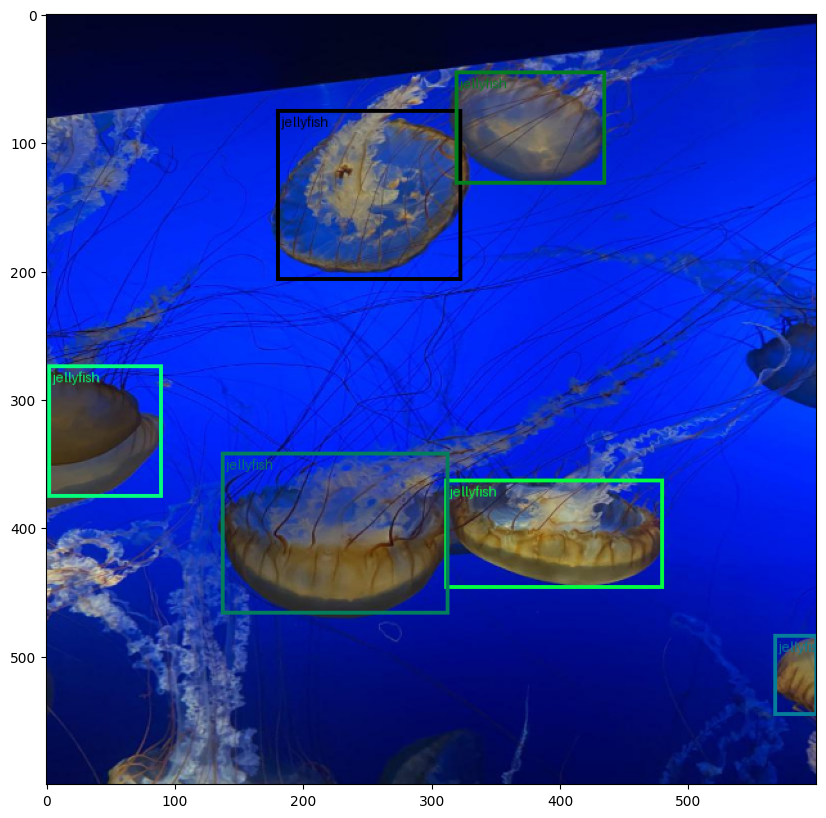

In [34]:
fig = plt.figure(figsize=(14, 10))
plt.imshow(draw_bounding_boxes(img_int,
    pred['boxes'][pred['scores'] > 0.8],
    [classes[i] for i in pred['labels'][pred['scores'] > 0.8].tolist()], width=3
).permute(1, 2, 0))